# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno = 276209 #this MUST be updated to your candidate number so that you get a unique data sample


In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [3]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [4]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['there', 'are', 'certain', 'people', 'in', 'the', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

#### Libraries used

In [5]:
## Utilities
import random, math
import pandas as pd 

# NLTK utilities
from nltk.corpus import stopwords
from nltk.classify.api import ClassifierI
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.classify import NaiveBayesClassifier

stop = stopwords.words('english')

### Utilities used through the data processing and classification

In [6]:
def normalise(wordlist):
    """
    input: wordlist is a list of words
    """
    filtered = [token.lower() for token in wordlist]

    for token in filtered:
        if token.isdigit():
            index = filtered.index(token)
            filtered[index] = 'NUM'
        elif token.isalnum() == True and token.isalpha() == False:
            index1 = filtered.index(token)
            filtered[index1] = 'Nth'

    return filtered

def remove_stop_words(docs):
    """
    input: docs is a list of words
    """
    filtered_punct = [token for token in docs if token.isalpha() and token not in stop]

    return filtered_punct

def lemma(docs):
    """
    input: dosc is a list of words
    """

    ##Initialize lemmatizer
    wnl = WordNetLemmatizer()

    filtered_lemma = [wnl.lemmatize(token) for token in docs]

    return filtered_lemma


def most_frequent_words(posfreq,negfreq,topk):
    """
    Input: Two frequency distributions a FreqDist type and a natural number
    Output: The top k pairs in the frecuency distribution as a list
    """
    dif_freq_dist = posfreq - negfreq

    n_word = [word[0] for word in dif_freq_dist.most_common(topk)]

    return n_word

def above_threshold(posfreq,negfreq,threshold):
    """
    Input: Two frequency distributions a FreqDist type and a natural number as the threshold
    output: A list that has just the words with a value above the threshold
    """
   
    dif_freq_dist = posfreq - negfreq

    words_above = [word for word, value in dif_freq_dist.items() if value > threshold]
    
    return words_above

### Add case and number normalisation, remove stop words and lemmatisation to training data

In this case, as our goal is to create a worldlist classifiers and to generate that wordlist automatically. One way to clean and pre-process the data and get the most relevant words and try to exclude repetitive words that repeat lots of times and do not offer important information is to apply `lower case and number normalisation` -- It takes the word, transforme it in lower case and replace the numbers and numbers mixted with letter to "NUM" and "NTH" as that information is not relevant for this classfier --, `remove stop words` -- It removes all stop words and commonly use un english (such as "the", "a", "an", "in") --, and `lemmatisation` -- It reduce the words to its base known as "lemma" that is the word that appers in a dictionary (such as "played" - "play" or "mice" - "mouse").

In [7]:
#now normalise and create bag-of-words FreqDist representations
training_norm = [(FreqDist(lemma(remove_stop_words(normalise(wordlist)))),label) for (wordlist,label) in training_data]
testing_norm = [(FreqDist(lemma(remove_stop_words(normalise(wordlist)))),label) for (wordlist,label) in testing_data]

#### Checking if our training and testing data is balanced

If the training and testing data are balance is possible to give proper conclusions when calculating the evaluation metrics.

In [8]:
cnt_train_pos = 0
cnt_train_neg = 0

cnt_test_pos = 0
cnt_test_neg = 0

for review, label in training_norm:
    if label == "pos":
        cnt_train_pos += 1
    else:
        cnt_train_neg += 1

for review, label in testing_norm:
    if label == "pos":
        cnt_test_pos += 1
    else:
        cnt_test_neg += 1

print(cnt_train_pos)
print(cnt_train_neg)

print(cnt_test_pos)
print(cnt_test_neg)

700
700
300
300


### Create the frequency distribution for positive and negative reviews

In this step, the training data is split in positive and negative reviews and it is created the frequency distribution of each review with the `FreqDist` that records the number of times each word is in the review to finally get the bag of words needed to generate the wordlist.

In [9]:
pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

for data in training_norm:
    
    if data[1] == 'pos':
        freq_dist_temp = FreqDist(data[0])
        pos_freq_dist += freq_dist_temp
    else:
        freq_dist_temp = FreqDist(data[0])
        neg_freq_dist += freq_dist_temp

### Display the output of the frecuency distribution for positive and negative reviews

This distribution is the general distribution, it is necessary to extract the most relevant ones, that in this case are the most frequent ones for both positive and negative reviews.

In [10]:
pos_rev_data = pd.DataFrame(list(pos_freq_dist.items()), columns = ["Word", "Frecuency"])
neg_rev_data = pd.DataFrame(list(neg_freq_dist.items()), columns = ["Word", "Frecuency"])

display(pos_rev_data)
display(neg_rev_data)

,Word,Frecuency
0,certain,78
1,people,551
2,world,461
3,talent,91
4,chose,9
...,...,...
22809,ignites,1
22810,narcissistically,1
22811,groupie,1
22812,oeuvre,1


,Word,Frecuency
0,appreciate,22
1,thriller,137
2,manipulates,3
3,viewer,99
4,thinking,73
...,...,...
21028,kool,1
21029,slooooow,1
21030,distract,1
21031,bandage,1


### Using the most frequent words function to get automatically the most relevant positive and negative words

In this case, it will be generated the wordlist automatically with two different methods to compare results and pick the best one. 

The methods are:

* `Most frequent words`: That takes the number of top words needed and the `positive` and `negative` frequency distribution and subtract the negative words to the positive ones and return the top `k` word pre-selected.

* `Above threshold words`: That works similar to the most frequent one but after the subtraction the parameter `k` set the words have that frequency or more in the bag of words.

In [11]:
top_k = 10

pos_train_most_frequent = most_frequent_words(pos_freq_dist, neg_freq_dist, top_k)
neg_train_most_frequent = most_frequent_words(neg_freq_dist, pos_freq_dist, top_k)

print(f"The 10 most relevant positive words in training data that are the most frequent are: {pos_train_most_frequent}")
print(f"The 10 most relevant negative words in training data that are the most frequent are: {neg_train_most_frequent}")

The 10 most relevant positive words in training data that are the most frequent are: ['film', 'life', 'also', 'great', 'one', 'story', 'well', 'best', 'performance', 'character']
The 10 most relevant negative words in training data that are the most frequent are: ['bad', 'movie', 'plot', 'minute', 'worst', 'look', 'supposed', 'nothing', 'could', 'boring']


In [12]:
threshold_k = 100

pos_train_threshold_frequent = above_threshold(pos_freq_dist, neg_freq_dist, threshold_k)
neg_train_threshold_frequent = above_threshold(neg_freq_dist, pos_freq_dist, threshold_k)

print(f"The 10 most relevant positive words in training data using threshold are: {pos_train_threshold_frequent}")
print(f"The 10 most relevant negative words in training data using threshold are: {neg_train_threshold_frequent}")

The 10 most relevant positive words in training data using threshold are: ['people', 'world', 'take', 'one', 'film', 'time', 'year', 'find', 'way', 'performance', 'also', 'life', 'job', 'right', 'great', 'love', 'first', 'however', 'character', 'father', 'well', 'best', 'see', 'true', 'seen', 'american', 'man', 'story', 'may', 'quite', 'new', 'jackie', 'perfect', 'although', 'many', 'always', 'family', 'war', 'disney', 'alien']
The 10 most relevant negative words in training data using threshold are: ['plot', 'movie', 'could', 'minute', 'even', 'look', 'supposed', 'nothing', 'bad', 'boring', 'worst', 'stupid']


2)
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


### Build three different classifiers 

In order to compare the performance on each one and pick the best one for our problem.

* The selected classifiers:
    * One based in most frequent words:
        * Is an instance of `SimpleClassifier` and takes the `k` top words as parameter and create the wordlist for positive and negative words. Then, the classify method takes a list of words that is a frequency distribution and add the value of each word if it is in the positive wordlist or subtract the value if it is in the negative wordlist.
    * One based on words above a selected threshold:
        * Same as the most frequent method is an instance of `SimpleClassifier` but it takes the `threshold` to create the positive and negative wordlist.
    * The one implemented in the `NLTK library`:
        * Takes the positive and negative reviews as parameters and classify with the same strategy as the most frequent wordlist and above threshold.

In [13]:
class SimpleClassifier(ClassifierI): 

    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 
    
    def classify(self, words): 
        score = 0

        for word, value in words.items():
            
            if word in self._pos:
                score += value
            if word in self._neg:
                score -= value
            
        if score == 0:
            score = random.randint(-1,1)
                
        return "neg" if score < 0 else "pos"

    def classify_many(self, docs): 
        return [self.classify(FreqDist(doc)) for doc in docs]

    def labels(self): 
        return ("pos", "neg")


class SimpleClassifier_mf(SimpleClassifier):
    
    def __init__(self,k):
        self._k=k
        self._pos=[]
        self._neg=[]

    def train(self, training_data):

        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()

        for word in training_data:
            if word[1] == 'pos':
                freq_dist_temp = FreqDist(word[0])
                pos_freq_dist += freq_dist_temp
            else:
                freq_dist_temp = FreqDist(word[0])
                neg_freq_dist += freq_dist_temp

        self._pos = most_frequent_words(pos_freq_dist, neg_freq_dist, self._k)
        self._neg = most_frequent_words(neg_freq_dist, pos_freq_dist, self._k)

class SimpleClassifier_ot(SimpleClassifier):
    
    def __init__(self,k):
        self._k=k
        self._pos=[]
        self._neg=[]

    def train(self, training_data):

        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()

        for word in training_data:
    
            if word[1] == 'pos':
                freq_dist_temp = FreqDist(word[0])
                pos_freq_dist += freq_dist_temp
            else:
                freq_dist_temp = FreqDist(word[0])
                neg_freq_dist += freq_dist_temp

        self._pos = above_threshold(pos_freq_dist, neg_freq_dist, self._k)
        self._neg = above_threshold(neg_freq_dist, pos_freq_dist, self._k)

3)

a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

### Calculating the accuracy, precision, recall and F1 score of the classifiers

To assess the performance of the classifiers there are different evaluation metrics that can be applied, such as:

* `Accuracy`: Takes the prediction and compares it with the real label, if the prediction is correct add one to the accuracy and finally calculate the porcentage that is the accurcy value divided in the total test data.

* `Precision`: Is the measure of the true positive predictions divided by the sum of true positives and false positives. Provides the information of the objects measured, how many were positive.

* `Recall`: Is the measure of the true positives divided by the sum of true positives and false negatives. Provides the information of the objects masured, how many did the classifier identify correctly as positive.

* `F1 score`: Combines the precision and recall that provides the balance between them being 2 times the precision times recall divided by the sum of precision and recall. Provides the information of the classifier ability to correctly identify positives predictions while minimizing false positives.

In [14]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):
    
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
        
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
        
    
    def precision(self):
        p=0

        p = self.TP/(self.TP + self.FP)
    
        return p
  
    def recall(self):
        r=0
    
        r = self.TP/(self.TP + self.FN)

        return r
  
    def f1(self):
        f1=0

        p = self.precision()
        r = self.recall()

        f1 = (2 * p * r)/(p + r)
      
        return f1 

#### Accuracy

To evaluate the performance of the classifier it os necesssary to create an `classifies_evaluate` function. 

The function takes two arguments, the `classifier` and the `test_data`. It separate the test data in the documents and their corresponding label, then, create the predictions using the test documents to finally compare the predictions with the actual labels and return the porcentage of accuracy.

In [15]:
def classifier_evaluate(cls, test_data):
    '''
    cls: an instance of a classifier object which has a classify method which returns "pos" or "neg"
    test_data: a list of pairs where each pair is a FreqDist rep of a doc and its label
  
    returns: float point number which is the accuracy of the classifier on the test data provided 
    '''
    acc = 0
    docs,label=zip(*test_data) #note this neat pythonic way of turning a list of pairs into a pair of lists
    #pass all of the docs to the classifier and get back a list of predictions
    predictions=cls.classify_many(docs)
    #zip the predictions with the labels and compare
    for prediction,goldlabel in zip(predictions,label):

        if prediction==goldlabel:
            acc+=1
    
    return acc / (len(test_data))

The accuracy for each classifier is estimated using the `classifier_evaluate` function

In [16]:
##Create the classifier
movie_classifier1_Basic = SimpleClassifier(pos_train_most_frequent, neg_train_most_frequent)

#Evaluate classifier
#The function requires two arguments:
# 1. Word list based classifer
# 2. A list (or generator) of labelled test items

score = classifier_evaluate(movie_classifier1_Basic, testing_data)
print(f"The Accuracy of the basic classifier is {score}")

The Accuracy of the basic classifier is 0.5866666666666667


In [17]:
##Create the classifier
movie_classifier2_mf = SimpleClassifier_mf(100)

#Evaluate classifier
#The function requires two arguments:
# 1. Word list based classifer
# 2. A list (or generator) of labelled test items

movie_classifier2_mf.train(training_norm)
score = classifier_evaluate(movie_classifier2_mf, testing_norm)
print(f"The Accuracy of the most frequent based classifier is {score}")

The Accuracy of the most frequent based classifier is 0.5933333333333334


In [18]:
##Create the classifier
movie_classifier3_ot = SimpleClassifier_ot(200)

#Evaluate classifier
#The function requires two arguments:
# 1. Word list based classifer
# 2. A list (or generator) of labelled test items

movie_classifier3_ot = SimpleClassifier_ot(200)
movie_classifier3_ot.train(training_norm)
score = classifier_evaluate(movie_classifier3_ot, testing_norm)
print(f"The Accuracy of the threshold based classifier is {score}")

The Accuracy of the threshold based classifier is 0.5433333333333333


#### Is it reasonable to evaluate the classifiers in terms of its accuracy?

Evaluate the classifiers in terms of its accuracy provides an overview of how the classifier is performing through some testing data, being intuitive as its output is the correctly classified objects divided by the total objects. Nevertheless, is important to confirm the specific characteristis of the data set and the goals of the classification task. 

if the data set is `balanced`, which means that the classes in the data set have the same number of data `e.g` 700 positive and negative reviews in training data and 300 positive and negative reviews in testing data. The accuracy will give an important insight on the classifier. Furthermore, if the main goal is to measure the performance of the classifier across all the positive and negative reviews by equal, is required to have a balanced data.

However, if the data is `imbalanced` `e.g` 90% of the data is labeled as positive reviews and just the other 10% of the data is related to negative reviews the classifier could reach a high accuracy by predicting just the positive ones that are the majority even if its performance predicting the minority class is poor. What it means is that the classifier is just performing good with one class but when it comes to the negative ones could be not as good.

Certainly, the `accuracy` as evaluation metric give relevant information if it is kept in mind the characteristics of the data, where a balance data will be necessary to give the best description for the classifier over all classes. Therefore, if the data available is imbalance it would not be reasonable to evaluate the classifier in terms of accuracy. Hence, there are other evaluation metrics that evaluate the classifier in termins of true positives, false positives, true negatives and false negatives such as precision, recall and F1-Score that may provided a better information.

#### Precision, recall and F1 score results

First is necessary to split the test data into the documents and its correspondig labels, and a pythonic way to do it is to use the `zip()` function in which with the `*` character along the variable. Is going to split the data in two equall list and make it possible to compare the classifier prediction with the actual label.

In [19]:
docs, labels = zip(*testing_norm)

#### Summary

In [20]:
"""Precision"""
sentiment1_precision = ConfusionMatrix(movie_classifier1_Basic.classify_many(docs), labels)
sentiment2_precision = ConfusionMatrix(movie_classifier2_mf.classify_many(docs), labels)
sentiment3_precision = ConfusionMatrix(movie_classifier3_ot.classify_many(docs), labels)

"""Recall"""
sentiment1_recall = ConfusionMatrix(movie_classifier1_Basic.classify_many(docs), labels)
sentiment2_recall = ConfusionMatrix(movie_classifier2_mf.classify_many(docs), labels)
sentiment3_recall = ConfusionMatrix(movie_classifier3_ot.classify_many(docs), labels)

"""F1-Score"""
sentiment1_f1 = ConfusionMatrix(movie_classifier1_Basic.classify_many(docs), labels)
sentiment2_f1 = ConfusionMatrix(movie_classifier2_mf.classify_many(docs), labels)
sentiment3_f1 = ConfusionMatrix(movie_classifier3_ot.classify_many(docs), labels)

In [21]:
# Simple Classifier
print("Evaluation metris for SimpleClassifier:\n")
print(f"Sentiment precision for SimpleClassifier: {sentiment1_precision.precision():.4f}")
print(f"Sentiment recall for SimpleClassifier: {sentiment1_recall.recall():.4f}")
print(f"Sentiment f1 for SimpleClassifier: {sentiment1_f1.f1():.4f}")
print("--------------------------------------------------------------------------")

## Most Frequent words classifier
print("Evaluation metrics for most frequent words classifier:\n")
print(f"Sentiment precision for most frequent words based classifier: {sentiment2_precision.precision():.4f}")
print(f"Sentiment recall for most frequent words based classifier: {sentiment2_recall.recall():.4f}")
print(f"Sentiment f1 for most frequent words based classifier: {sentiment2_f1.f1():.4f}")
print("--------------------------------------------------------------------------")

## Above threshold classifier
print("Evaluation metrics for above threshold words classifier:\n")
print(f"Sentiment precision for threshold based classifier: {sentiment3_precision.precision():.4f}")
print(f"Sentiment recall for threshold based classifier: {sentiment3_recall.recall():.4f}")
print(f"Sentiment f1 for threshold based classifier: {sentiment3_f1.f1():.4f}")
print("--------------------------------------------------------------------------")

Evaluation metris for SimpleClassifier:

Sentiment precision for SimpleClassifier: 0.5469
Sentiment recall for SimpleClassifier: 0.9133
Sentiment f1 for SimpleClassifier: 0.6850
--------------------------------------------------------------------------
Evaluation metrics for most frequent words classifier:

Sentiment precision for most frequent words based classifier: 0.5533
Sentiment recall for most frequent words based classifier: 0.9867
Sentiment f1 for most frequent words based classifier: 0.7090
--------------------------------------------------------------------------
Evaluation metrics for above threshold words classifier:

Sentiment precision for threshold based classifier: 0.5219
Sentiment recall for threshold based classifier: 0.9500
Sentiment f1 for threshold based classifier: 0.6737
--------------------------------------------------------------------------


#### Estimating and displaying the classifiers evaluation metrics

The `get_metrics` function takes the classifiers dictionary as parameter and calculate the evaluation metrics for each classifier using the `ConfusionMatrix` class where there are all the methods used to estimate each metric and stores all the information in a list with the name, accuracy, precision, recall and F1-Score for each classifier. 

This list is then transform to a data frame and set each column of that new data frame to the name, accuracy, precision, recall and F1-Score. Finally plot the information in the dataframe in a bar chart where the y axis represents the numeric representation of each classifier and the x axis represents the classifiers evaluated.

In [22]:
def get_metrics(classifiers):

    """
    input: A dictionary of classifiers with a pre defined name to work properly and its value is the created classifier

    output: A dictionary of dictionaries were the columns are the classifier and the rows the number of words in wordlist
    """
    all_results=[]
    for name,classifier in classifiers.items():
        
        if name == "Word List MF":
            classifier.train(training_norm)
            accuracy = classifier_evaluate(classifier,testing_norm)
            sentiment = ConfusionMatrix(classifier.classify_many(docs), labels)
            precision = sentiment.precision()
            recall = sentiment.recall()
            f1 = sentiment.f1()
            all_results.append((name,accuracy, precision, recall, f1))
            
        elif name == "Word List Thresh":
            classifier.train(training_norm)
            accuracy = classifier_evaluate(classifier,testing_norm)
            sentiment = ConfusionMatrix(classifier.classify_many(docs), labels)
            precision = sentiment.precision()
            recall = sentiment.recall()
            f1 = sentiment.f1()
            all_results.append((name,accuracy, precision, recall, f1))

        elif name == "NLTK Naive Bayes":
            accuracy = classifier_evaluate(classifier,testing_norm)
            sentiment = ConfusionMatrix(classifier.classify_many(docs), labels)
            precision = sentiment.precision()
            recall = sentiment.recall()
            f1 = sentiment.f1()
            all_results.append((name,accuracy, precision, recall, f1))
            
        else:
            accuracy=classifier_evaluate(classifier,testing_norm)
            sentiment = ConfusionMatrix(classifier.classify_many(docs), labels)
            precision = sentiment.precision()
            recall = sentiment.recall()
            f1 = sentiment.f1()
            
            all_results.append((name,accuracy, precision, recall, f1))

    return all_results

,Name,Accuracy,Precision,Recall,F1-Score
0,Basic Classifier,0.580000,0.546906,0.913333,0.684145
1,Word List MF,0.606667,0.569038,0.906667,0.699229
2,NLTK Naive Bayes,0.673333,0.607884,0.976667,0.749361
3,Word List Thresh,0.503333,0.501672,1.000000,0.668151


(0.0, 1.0)

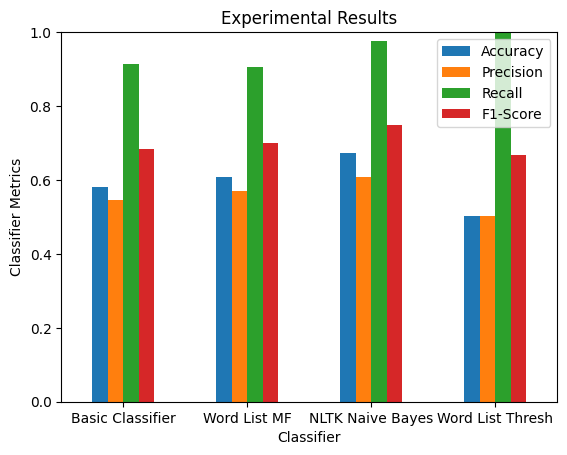

In [23]:
##Wordlist and threshold size
word_list_size = 20
threshold=50

## The names must be these ones so get_metrics work
classifiers={"Basic Classifier":SimpleClassifier(pos_train_most_frequent, neg_train_most_frequent),
            "Word List MF":SimpleClassifier_mf(word_list_size),
            "NLTK Naive Bayes":NaiveBayesClassifier.train(training_norm),
            "Word List Thresh":SimpleClassifier_ot(threshold)}

results = get_metrics(classifiers)
## Create the  metrics list to add them as column names
metrics = ["Name", "Accuracy", "Precision" ,"Recall", "F1-Score"]
## Create the data frame based in the results
df = pd.DataFrame(results, columns = metrics)

display(df)
ax = df.plot.bar(title="Experimental Results",legend=True, x =0, rot = 0)
ax.set_ylabel("Classifier Metrics")
ax.set_xlabel("Classifier")
ax.set_ylim(0,1.0)

#### Conclusion

* The classifier with the best performance is the `NLTK Naive Bayes` classifier which will be compared in the next section with the second best classifier that in this case is the `Word list Most Frequent` classifier. 

* The `Basic Classifier` and the `Word list Most Frequent` had similar results, even though the second one has better performance in general, this is due to the fact that the training data was pre-processed and the `wordlist` used to train the classifier had some words that describe an important variety of positive and negative sentiment. Likewise, the high `Recall` means that both classifiers are good at predicting positive objects even if some of them are false positives.

* The `Word list Above Threshold` classifer had the lowest results in general, selecting the predictions to a probability of 50% that is close to just guess the sentiment for each review. This happens as the list of words automatically generated with the `Above Threshold` method does not provide words that describe a general positive or a negative review, hence when the `classify` method is used no word add or subtract a value to the `score` variable and the classifier guess the output if the score is `0`.

4)
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results.

[12.5\%]

#### The NLTK Naive Bayes Classifier

To use the `NLTK Naive Bayes` classifier is necessary to import the `nltk.classify` library and `NaiveBayesClassifier` class to train the model. 

The `NLTK Naive Bayes` works under some assumptions:

1. The order of the words is ignored.
2. It uses a `multinominal` event, hence the number of times a word occur in a document is taken into accout.

Moreover, the `NLTK Naive Bayes` is base on different probabilities due the classes and documents, those are:

* `Class Priors`: Are the probability of one document to be either `positive review` or `negative review` in this case. It takes the total number of positive reviews divided by the total documents.

* `Conditional Probabilities`: This are the probabilities that (In this case) the document is either positive or negative. In order to simplify it makes the assumption that the probability that the different words occur in a document are independet of one another. Then we have: 
\begin{aligned}
P(\,d\,|\,c\,) &=& P(\,\{w_1,\ldots,w_n\}\,|\,c\,)
&=& \prod_{i=1}^n P(\,w_i\,|\,c\,)
\end{aligned}

On the other hand, `NLTK Naive Bayes` implement some other strategies to improve the prediction, such as:

* `Add-One Smoothing`: To avoid cero probabilities as it is been done the product of probabilities it is added one extra count (A constant that is usually 1) to the known vocabulary --Words that appear in training data documents-- thus the words that appear in one class of documento but not in the other have now a small probability to occur and the probability es never going to be cero.

* `Ignore OOV words`: Ingnore all the words that are not in the known vocabulary.

* `Avoid Underflow`: With a thousands of documents with a large number of paragraphs there will be a multiplications of large numbers of very small probabilities. Therefore, to avoid this problem it is added the `Log` of the probability of a document to be in a class and rather than calculating conditional probabilities, it will be calculating `log conditional probabilities`. The we have:
\begin{aligned}
\log(P(\,d\,|\,c\,))
\end{aligned}

This explanation is based on the `lab_4_1` content for the module Applied Natural Language Processing by Dr Jeff Mitchell in the University of Sussex in 2023.

In [24]:
from nltk.classify import NaiveBayesClassifier

#note that the NaiveBayesClassifier.train() method is a class method which returns the classifier object.
#this is different to ours and other classifiers which are first instantiated and then trained via an object method
nltk_nb=NaiveBayesClassifier.train(training_norm)

nltk_nb.classify_many(docs)

cm=ConfusionMatrix(nltk_nb.classify_many(docs),labels,classes=('pos','neg'))
nltk_nb_metrics = []

print("Evaluation metrics for NLTK Naive Bayes classifier:\n")
print(f"Sentiment accuracy for the NLTK Naive Bayes is: {classifier_evaluate(nltk_nb, testing_norm):.4f}")
print(f"Sentiment accuracy for the NLTK Naive Bayes is: {cm.precision():.4f}")
print(f"Sentiment precision for the NLTK Naive Bayes is: {cm.precision():.4f}")
print(f"Sentiment recall for the NLTK Naive Bayes is: {cm.recall():.4f}")
print(f"Sentiment F1-score for the NLTK Naive Bayes is: {cm.f1():.4f}")

nltk_nb_metrics.append(("NLTK NB", classifier_evaluate(nltk_nb, testing_norm),cm.precision(), cm.recall(), cm.f1()))

Evaluation metrics for NLTK Naive Bayes classifier:

Sentiment accuracy for the NLTK Naive Bayes is: 0.6733
Sentiment accuracy for the NLTK Naive Bayes is: 0.6079
Sentiment precision for the NLTK Naive Bayes is: 0.6079
Sentiment recall for the NLTK Naive Bayes is: 0.9767
Sentiment F1-score for the NLTK Naive Bayes is: 0.7494


#### Extract the information of the best wordlist based classifier the most frequent words from the last question

In [25]:
df_mf = pd.DataFrame(results[1])
df_mf_t = df_mf.transpose()
df_mf_t.columns = metrics
df_mf_t

,Name,Accuracy,Precision,Recall,F1-Score
0,Word List MF,0.606667,0.569038,0.906667,0.699229


In [26]:
metrics = ["Name", "Accuracy", "Precision" ,"Recall", "F1-Score"]
df_nb = pd.DataFrame(nltk_nb_metrics, columns = metrics)

df_mf_nb_compared = pd.concat([df_mf_t, df_nb])
display(df_mf_nb_compared)

,Name,Accuracy,Precision,Recall,F1-Score
0,Word List MF,0.606667,0.569038,0.906667,0.699229
0,NLTK NB,0.673333,0.607884,0.976667,0.749361


(0.0, 1.0)

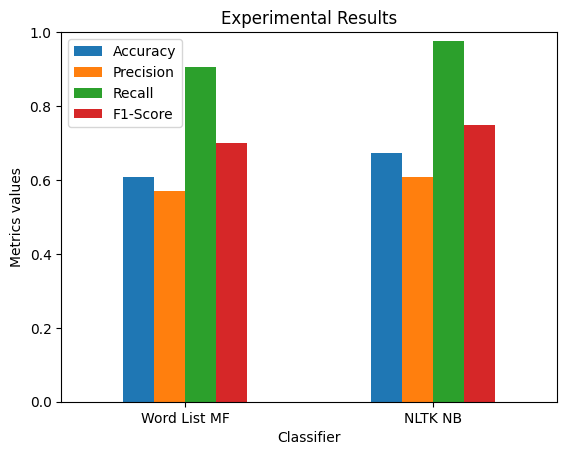

In [27]:
ax = df_mf_nb_compared.plot.bar(title="Experimental Results", legend=True, x = 0,rot = 0)
ax.set_ylabel("Metrics values")
ax.set_xlabel("Classifier")
ax.set_ylim(0,1.0)

#### Conclusion

* The `NLTK Naive Bayes` classifier evidence a better performance in this particular problem.

* One way to improve the `Word list Most Frequent` classifier is to manually add and delete some words that are not relevant to either predict a positive or negative sentiment.

* One way to possibly improve both classifiers, is to try different pre-processing techniques as using `stemming` instead of `lemmatisation`, do not removing `stop words`, changing the size of training and testing data and add more data to the data set.

* An important evaluation metric as it is the `F1-Score` is higher with the `NLTK Naive Bayes`, this is due to the fact that the `NLTK Naive Bayes` uses more probabilistic resources to estimate the prediction and used all the known words in the training data, on the other hand, the `Word list Most Frequent` is also based on the words in training data however exclude several words when the top `k` number is selected and some of the automatically selected words may not be completely related to a positive or negative review.

* In this case, all the parameters except the `Recall` evidence a better performance in `NLTK Naive Bayes` fact that suggest this classifier predict the positive reviews properly although predicts some false positives.

* With the used data, as it is balanced, the `Accuracy` provides relevant information. As showed in the bar chart the `Accuracy` is 0.67 with the `NLTK Naive Bayes` classifier which means that fails in around 30% of the prediction that explains the high `Recall` as the `Accuracy` measures the general performance over all classes.

5)
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


#### Changing the `wordlist` length on the wordlist classifier based on most common words

During the experiment it was confirm that the `Word list Most Frequent` classifier has the best performance when compared to the `Word list Above Threshold` and `Basic Classifier`. Thus, `Word list Most Frequent` was selected to carry out the experiment to calculate the performance through evaluation metrics as `Accuracy`, `Precision`, `Recall` and `F1-Score` with different `wordlist` sizes.

The code implemented for this experiment is similar to the one used befored where it was comparared all the classifiers, in this case, the goals is to measure the performance of the classifier within a range of `wordlist` lenght. Hence, the structure of using the dictionary to iterate through it, evaluate the classifier and get the metrics is the same, however, in this case is better to store the information in a dictionary of dictionaries where the outter dictionary keys are the length of the `wordlist` and the values are the metrics so the information is clear and ordered and easier to plot.

In [28]:
## My range test - Number from 2 to 30 in steps of 2
my_range_test = range(2, 50)

## Initialise outter dictionaries
results_test_wordlist_length_accuracy = {}
results_test_wordlist_length_precision = {}
results_test_wordlist_length_recall = {}
results_test_wordlist_length_f1 = {}

## Loop through the lenght of the experiment range
for wordlist_length in my_range_test:

    ## Initialise the inner dictionaries
    accuracy_results = {}
    precision_results = {}
    recall_results = {}
    f1_results={}

    ## The names must be these ones so get_metrics work
    classifiers={"Word List MF":SimpleClassifier_mf(wordlist_length)}

    ## Loop through the dictionary with the classifiers
    for name,classifier in classifiers.items():
        
        ## Get the metrics
        if name == "Word List MF":
            classifier.train(training_norm)
            accuracy = classifier_evaluate(classifier,testing_norm)
            sentiment = ConfusionMatrix(classifier.classify_many(docs), labels)
            precision = sentiment.precision()
            recall = sentiment.recall()
            f1 = sentiment.f1()
            ##Add the metrics to a dictionary
            accuracy_results[name] = accuracy
            precision_results[name] = precision
            recall_results[name] = recall
            f1_results[name] = f1
            

    ##Create the dictionary of dictionaries where outter key is the wordlist length
    results_test_wordlist_length_accuracy[wordlist_length] = accuracy_results
    results_test_wordlist_length_precision[wordlist_length] = precision_results
    results_test_wordlist_length_recall[wordlist_length] = recall_results
    results_test_wordlist_length_f1[wordlist_length] = f1_results

In [29]:
##Data frame with classifiers precision
df_accuracy=pd.DataFrame(results_test_wordlist_length_accuracy)
df_accuracy=df_accuracy.transpose()

##Data frame with classifiers precision
df_precision=pd.DataFrame(results_test_wordlist_length_precision)
df_precision=df_precision.transpose()

##Data frame with classifiers recall
df_recall=pd.DataFrame(results_test_wordlist_length_recall)
df_recall=df_recall.transpose()

##Data frame with classifiers F1 score
df_f1=pd.DataFrame(results_test_wordlist_length_f1)
df_f1=df_f1.transpose()

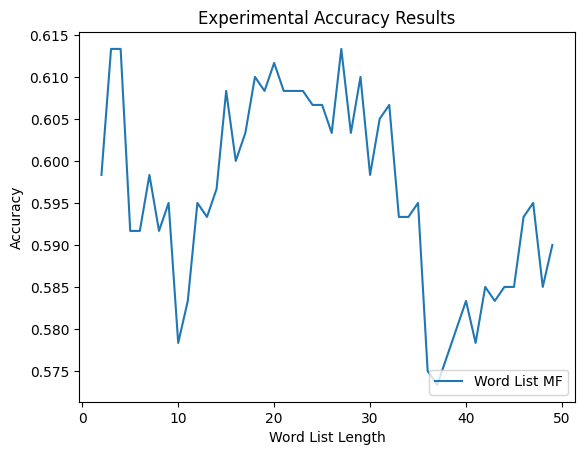

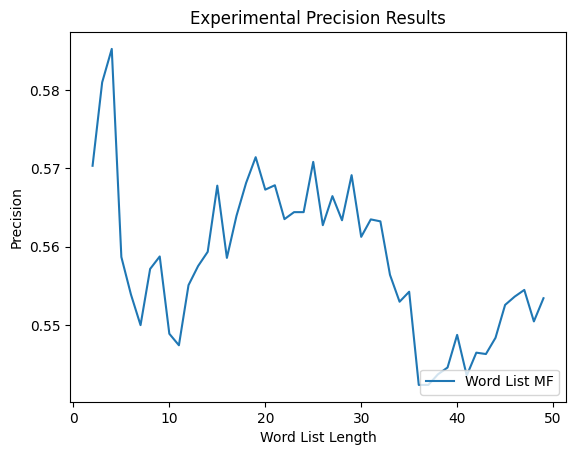

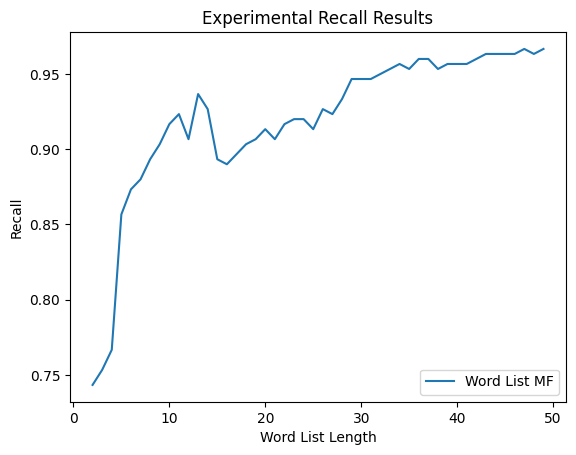

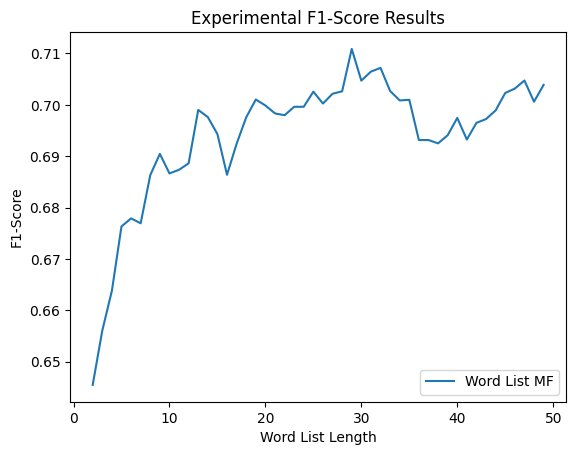

In [30]:
##Plot the classifiers accuracy
ax = df_accuracy.plot(kind="line",title="Experimental Accuracy Results")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Word List Length")
ax.legend(loc="lower right")

##Plot the classifiers precision
ax = df_precision.plot(kind="line",title="Experimental Precision Results")
ax.set_ylabel("Precision")
ax.set_xlabel("Word List Length")
ax.legend(loc="lower right")

##Plot the classifiers recall
ax = df_recall.plot(kind="line",title="Experimental Recall Results")
ax.set_ylabel("Recall")
ax.set_xlabel("Word List Length")
ax.legend(loc="lower right")

##Plot the classifiers F1 score
ax = df_f1.plot(kind="line",title="Experimental F1-Score Results")
ax.set_ylabel("F1-Score")
ax.set_xlabel("Word List Length")
ax.legend(loc="lower right")

#### Conclusions

* The `Accuracy` evidence that even in this case, using `balance` data and pre-processed with `case and number normalisation`, `stop words removal` and `lemmatisation` this metric does not provide itself enough information to make a decision in what is the best wordlist length.

* There is an interesting result in `Precision` line chart as has a peak when the `wordlist` lenght is around `5`. This could be due to the fact that the first 5 words in the wordlist are general (such as:'film', 'life', 'also', 'great', 'one' in positive and 'bad', 'movie', 'plot', 'minute', 'worst' in negative)thus the classifier predicts correctly some of them as positive or negative because it has some words as 'great' or 'worst' that are highely used in positive and negative reviews and the `precision` raise to almost `0.6`.

* A `wordlist` of around `20` words reveals that is a good option to be used in the classifier because in all metrics confirms a good performance, moreover the `Precision`, `Recall` and `F1-Score` results confirms that using more than `20` words in the `wordlist` would lead to reduce the precision considerably.

* The `Recall` shows a valley with a `wordlist` of `20` words, in this particular case this is not a bad result, as the goal of the classifier is to classify properly either positive and negative reviews, hence a extremely high recall may not be the best answer since that means the model is highly efective capturing positive reviews but is not as good with the negative ones.

* All `metrics` show that with around `37` words the classifier performance goes down, this could be explain as there are now plenty words in the lists, the classifier may deal with some scores equal to `0` and then the prediction became random. 

* The `wordlist` length in this scenario has a positive impact in the classifier performance, however is necessary to interpret the graphs properly to identify the best `wordlist` lenght for the reason that not always a high value in one metric means that is the best for a particular case. E.g the `Recall` valley and the fluctuation in `Precision`.

#### Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?

The recommendation of either a `wordlist` classifier or a `Naive Bayes` classifier is related to the problem wanted to solve. If the problem has not a high complexity were the words matching is effective, the data available is limited and if the problem requires certain decision base in specific words, the best option is the `wordlist` classifier. On the other hand, for more complex scenarios where the classifier was trained with diverse and representative data for that problem, the statistical approach is a great advantage, furthermore, even if there are some weakness in the `Naive Bayes` classifier, it has already implemented some strategies that help to mitigate problems (such as: Add-One smoothing, ignore OOV words and Avoid underflow). 

Certainly, a `wordlist` classifier is not as complex and robust as the `Naive Bayes`. Nevertheless, is possible to implement a `wordlist` classifier with no high complexity, limited data or when some espefici words lead to specific decision. In other scenarios the best option is to use a `Naive Bayes` classifier where the variety of words is higher, the statistical approach can capture more complex relationships between words.



Andres Sebastian Salazar Alturo
Artificial intelligence and adaptive systems master's student
276209

In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath

import io
from nbformat import current

from google.colab import drive
drive.mount('/content/drive')

filepath="/content/drive/MyDrive/Colab Notebooks/ANLPassignment2023.ipynb"
question_count=432

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))